https://otexts.com/fpp3/

# Note: I am just focusing on testing models to forecast SPY for now, will try other ETFs in the future

## Import Libraries

In [452]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta
from sklearn.metrics import root_mean_squared_error
from pmdarima.arima import auto_arima
from helper import perform_adf_test, transform_data, split_data, undo_transformations, evaluate_model, random_walk, evaluate_rw

## Data Collection

In [453]:
# Get tickers we are interested in
tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA'] # common etfs (https://www.bankrate.com/investing/best-index-funds/#NASDX)
#test_tickers = ['BTC-USD']
NUM_TICKERS = len(tickers)

# Set start and end dates that specify the amount of data we will pull
START_DATE = datetime.today() + relativedelta(months=-4)
END_DATE = datetime.today()

# Pull data using API
data = yf.download(tickers, start=START_DATE, end=END_DATE)['Adj Close']

spy_data = yf.download('SPY', start = START_DATE, end =END_DATE)['Adj Close']

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  1 of 1 completed


## EDA

In [454]:
# Checking for null values
data.isna().sum()

Ticker
DIA      0
NASDX    0
QQQ      0
SPY      0
VOO      0
dtype: int64

In [455]:
# Get data into long format so we can visualize it
long_data = pd.melt(data.reset_index(), id_vars = ['Date'], value_vars = tickers)

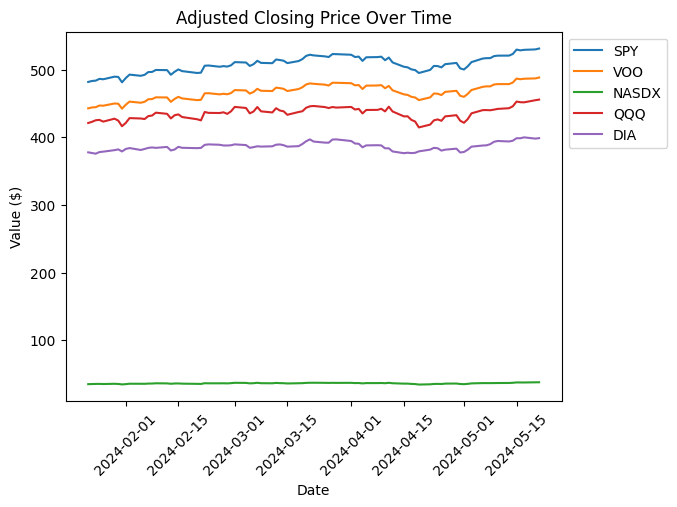

In [456]:
# Time Series Plots
sns.lineplot(data = long_data, x = 'Date', y = 'value', hue = 'Ticker');
plt.title('Adjusted Closing Price Over Time');
plt.xticks(rotation = 45);
plt.ylabel('Value ($)');
plt.legend(loc = 'upper left', bbox_to_anchor=(1, 1));
    

EDA on SPY

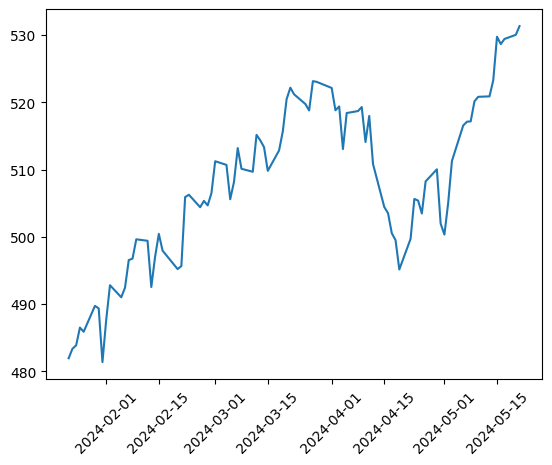

In [457]:
plt.plot(spy_data);
plt.xticks(rotation = 45);

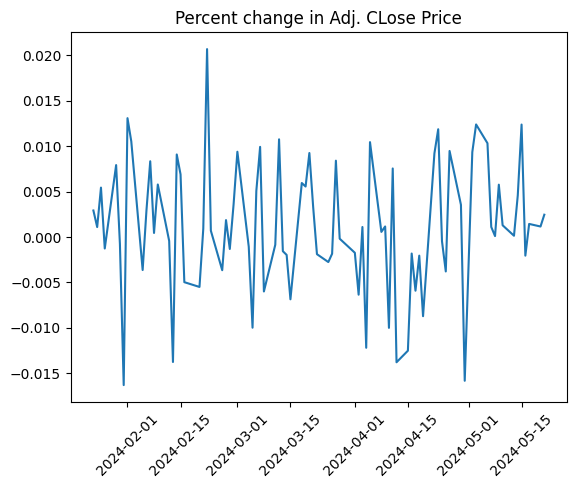

In [458]:
plt.plot(spy_data.pct_change());
plt.xticks(rotation = 45);
plt.title('Percent change in Adj. CLose Price');

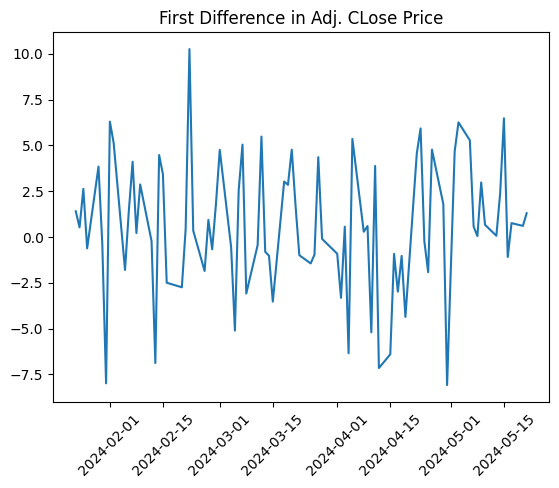

In [459]:
plt.plot(spy_data.diff());
plt.xticks(rotation = 45);
plt.title('First Difference in Adj. CLose Price');

Here we notice that the 1st difference of the stock price for spy is stationary.

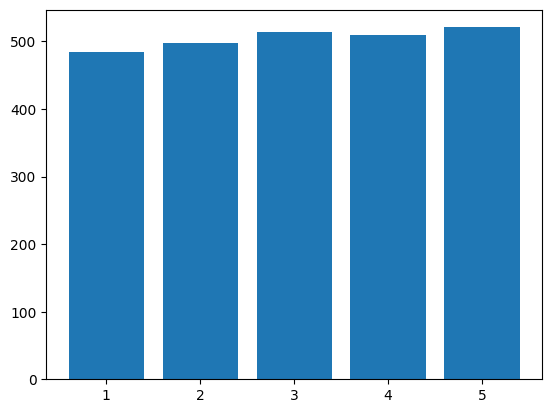

In [460]:
price_by_month = spy_data.groupby(spy_data.index.month).median() 
plt.xticks(range(1, 13))
plt.bar(price_by_month.index, price_by_month);

How does this compare to Bitcoin and Coinbase?

In [461]:
crypto_equities_tickers = ['SPY', 'VOO', 'NASDX', 'QQQ', 'DIA', 'BTC', 'COIN'] 

crypto_equities = yf.download(crypto_equities_tickers, start=START_DATE, end=END_DATE)['Adj Close']

[*********************100%%**********************]  7 of 7 completed


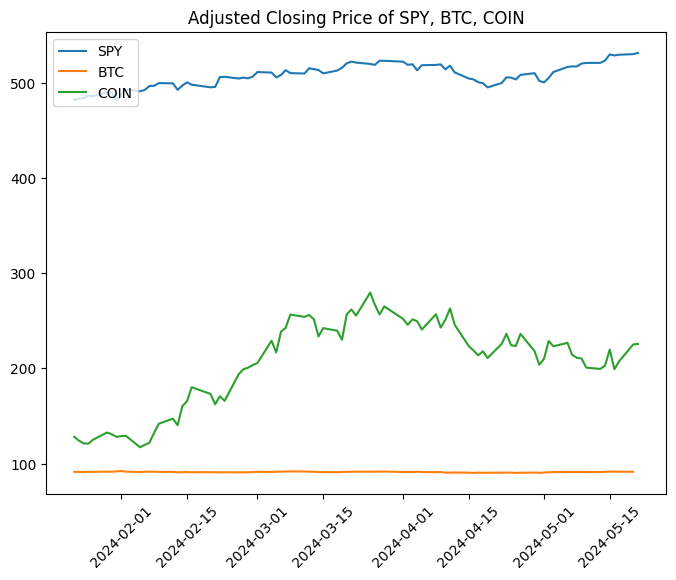

In [462]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(crypto_equities['SPY']);
ax.plot(crypto_equities['BTC']);
ax.plot(crypto_equities['COIN']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(data.index.min(), date.today());
plt.xticks(rotation = 45);
ax.legend(labels = ['SPY', 'BTC', 'COIN'], loc = 'upper left');

C:\Users\kevoi\AppData\Local\Temp\ipykernel_15380\572884942.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = crypto_equities.pct_change().dropna()


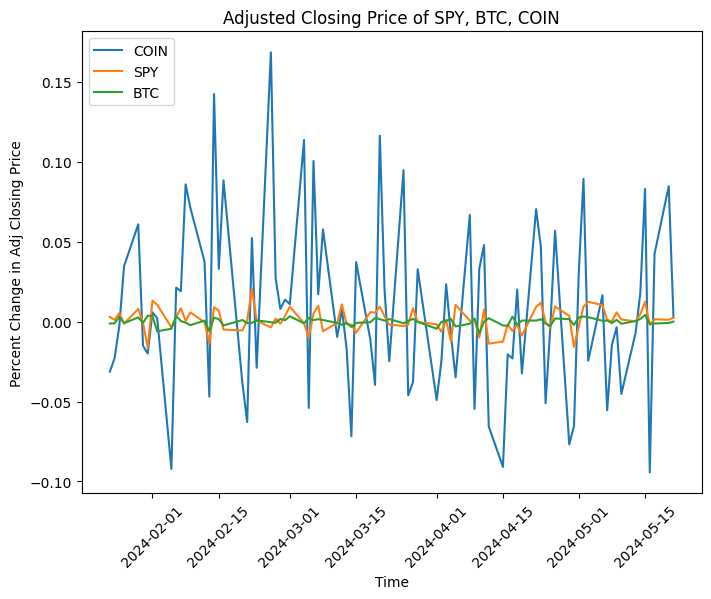

In [463]:
# Returns
returns = crypto_equities.pct_change().dropna()

fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(returns['COIN']);
ax.plot(returns['SPY']);
ax.plot(returns['BTC']);
plt.title('Adjusted Closing Price of SPY, BTC, COIN');
#plt.xlim(datetime(2020, 10, 1), date.today());
plt.xticks(rotation = 45);
plt.ylabel('Percent Change in Adj Closing Price');
plt.xlabel('Time')
ax.legend(labels = ['COIN', 'SPY', 'BTC'], loc = 'upper left');

Other vizs to try: lagplots

Autocorrelation is the correlation between lagged values of a time series. e.g. You can measure the autocorrelation of the price of Bitcoin today and the price 2 days ago.

Important Note: Autocorrelation takes into the account both the indirect and direct effects that the price 2 days ago had on today's price. An example of an indirect effect is the price 2 days ago affected the price 1 day ago which affected the price today.

If we wanted to only measure direct effect we can use the PACF (Partial Autocorrelation Function).

for more info(https://www.youtube.com/watch?v=DeORzP0go5I&t=465s)

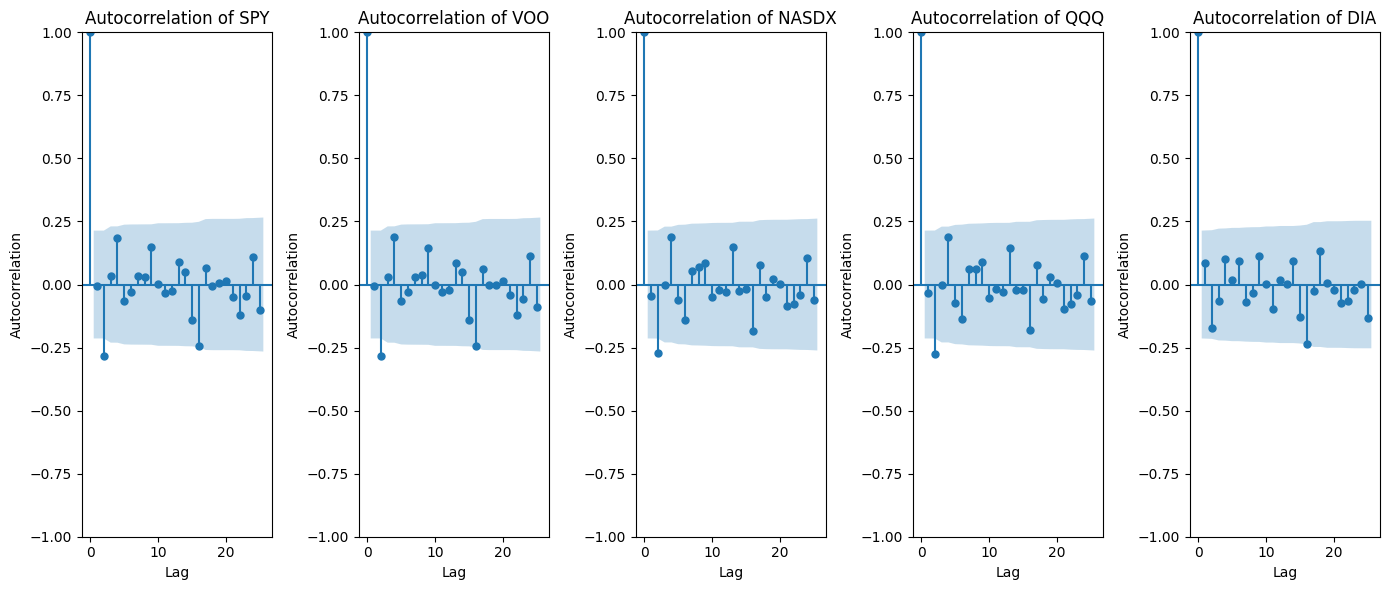

In [464]:
# ACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize=(14, 6))

# first difference makes the data have stationarity so we can create the ACF and PACF plots, which is why we plot the first difference

for i, ticker in enumerate(tickers):
  plot_acf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25) #.diff() calculates the first difference
  ax[i].set(title = f'Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Autocorrelation')

plt.tight_layout()
plt.show()

The ACF plot tells us how correlated today's price is with the kth previous day's price. We are looking for points outside the blue band. Disregard x = 0 because that is the correlation of today's price with itself.

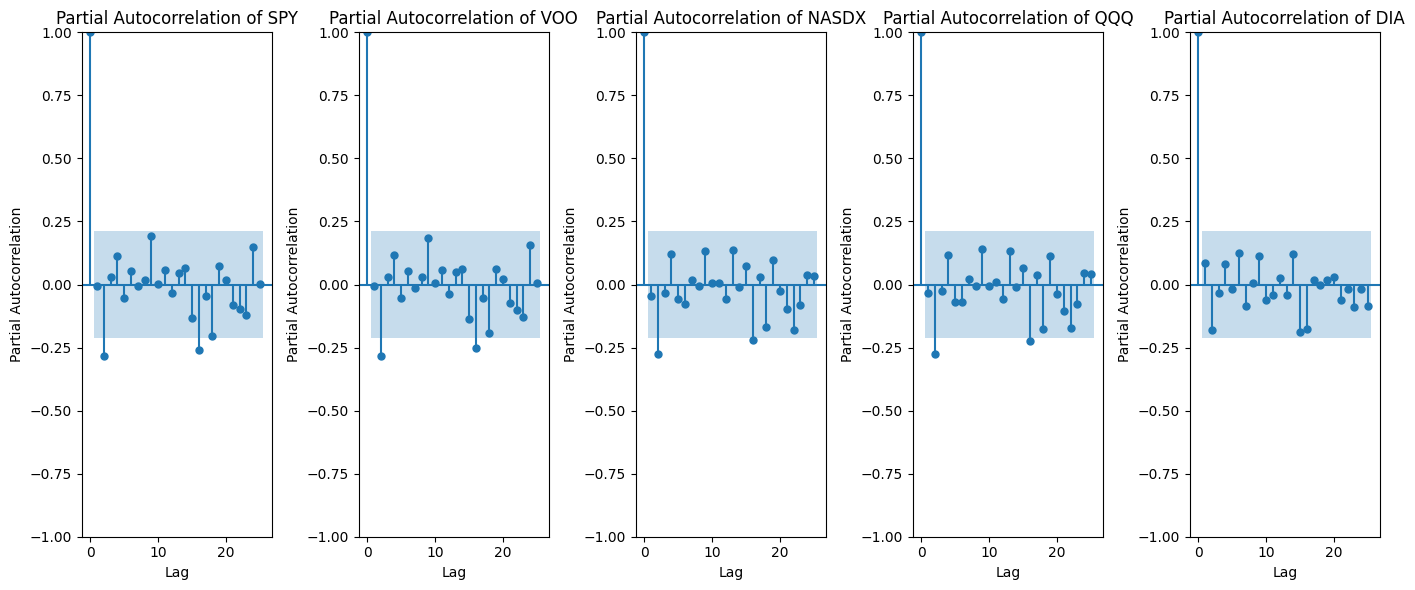

In [465]:
# PACF plots
fig, ax = plt.subplots(1, NUM_TICKERS, figsize= (14, 6))

for i, ticker in enumerate(tickers):
  plot_pacf(data[ticker].diff(periods=1).dropna(), ax = ax[i], lags = 25)
  ax[i].set(title = f'Partial Autocorrelation of {ticker}', xlabel = 'Lag', ylabel = 'Partial Autocorrelation')

plt.tight_layout()
plt.show()

## ACF and PACF plots for SPY

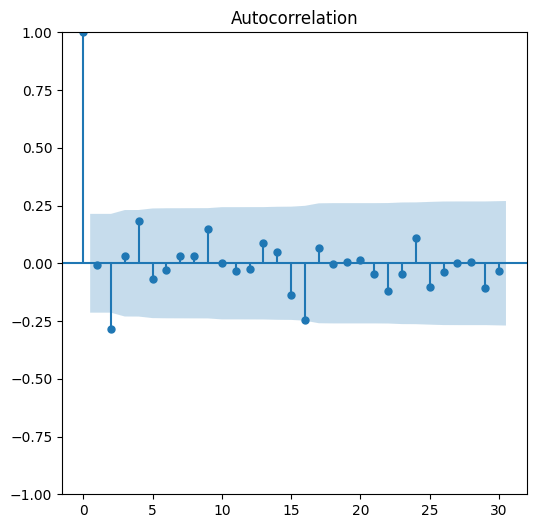

In [466]:
fig, ax = plt.subplots(figsize=(6,6))
fig = plot_acf(spy_data.diff().dropna(), lags = 30, ax = ax)

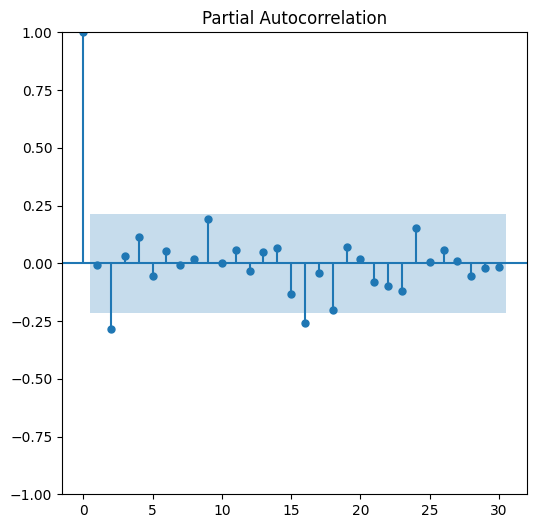

In [467]:
fig, ax = plt.subplots(figsize=(6,6))
fig = plot_pacf(spy_data.diff().dropna(), lags = 30, ax = ax)

In both the ACF and PACF plots, we notice that there are not many lags that have partial autocorrelation or autocorrelation significantly greater than 0.

Stationary Tests (Dicky-Fuller)

In [468]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -1.511300
p-value: 0.527914

ADF Test for VOO
ADF Statistic: -1.224269
p-value: 0.663070

ADF Test for NASDX
ADF Statistic: -2.053971
p-value: 0.263421

ADF Test for QQQ
ADF Statistic: -1.969389
p-value: 0.300154

ADF Test for DIA
ADF Statistic: -1.849582
p-value: 0.356138



All time series were not stationary, which is needed for the models we will use. To fix this, we use first difference

# Modelling

## Data Preparation

In [469]:
transformed_data = data.copy()
transformed_data = transform_data(transformed_data)

In [470]:
# Conduct ADF Test on all tickers
for ticker in tickers:
  print(f"ADF Test for {ticker}")
  perform_adf_test(transformed_data[ticker].values)
  print()

ADF Test for SPY
ADF Statistic: -8.440772
p-value: 0.000000

ADF Test for VOO
ADF Statistic: -8.442069
p-value: 0.000000

ADF Test for NASDX
ADF Statistic: -8.554608
p-value: 0.000000

ADF Test for QQQ
ADF Statistic: -8.511913
p-value: 0.000000

ADF Test for DIA
ADF Statistic: -7.252132
p-value: 0.000000



In [471]:
TRAIN_END = datetime(2024, 3, 31)  # date to train the model until
TEST_END = datetime(2024, 4, 30) # date to start forecasting after

In [472]:
spy_train, spy_test = split_data(transformed_data, 'SPY', TRAIN_END, TEST_END)
og_spy_train, og_spy_test = split_data(data, 'SPY', TRAIN_END, TEST_END)

Testing undo_transformations() function

In [473]:
test_transformed_values = undo_transformations(spy_train, pd.Series(og_spy_train.iloc[0]))

In [474]:
assert (og_spy_train[1:].values == test_transformed_values).all()

## Model Fitting & Evaluation

## Model 1: ARIMA 

In [475]:
# Trying auto arima
autoarima = auto_arima(y = og_spy_train, start_p = 1, d = 0, start_q = 1, max_p = 14, max_q = 14, max_d = 2, seasonal=False)
autoarima

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True)

The auto arima function tells us that an ARIMA(1,0,0) model is the best fit. This is equivalent to an AR 1 model.

This is surprising as the from the EDA, we saw that the data was clearly not stationary, so it is interesting that the differncing component of the ARIMA model is 0.

In [476]:
# ARIMA model without doing the differencing manually
model = ARIMA(og_spy_train, order = (1, 0, 0))
model_fit = model.fit()

In [477]:
forecast = model_fit.get_prediction(start = og_spy_test.index[0], end = og_spy_test.index[-1])
predictions = forecast.predicted_mean
conf_ints = forecast.conf_int()
conf_ints.columns = ['lower', 'upper']

In [478]:
if type(og_spy_test.index) != type(predictions.index):
    og_spy_test.index = og_spy_test.index.to_timestamp()
df = pd.concat([og_spy_test, predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']

print(f"RMSE of AUTOARIMA: {root_mean_squared_error(df['actual'], df['predicted'])}")

RMSE of AUTOARIMA: 6.91019887713507


In [479]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    SPY   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -130.319
Date:                Tue, 21 May 2024   AIC                            266.637
Time:                        21:01:32   BIC                            272.251
Sample:                    01-22-2024   HQIC                           268.759
                         - 03-28-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        502.7266     13.877     36.228      0.000     475.529     529.925
ar.L1          0.9770      0.050     19.581      0.000       0.879       1.075
sigma2        12.5245      2.385      5.252      0.0

The 1st lag component of the AR model is significant.

In [480]:
# Variables created for plotting
og_spy_train_timestamp = og_spy_train.copy()
og_spy_train_timestamp.index = og_spy_train_timestamp.index.to_timestamp()

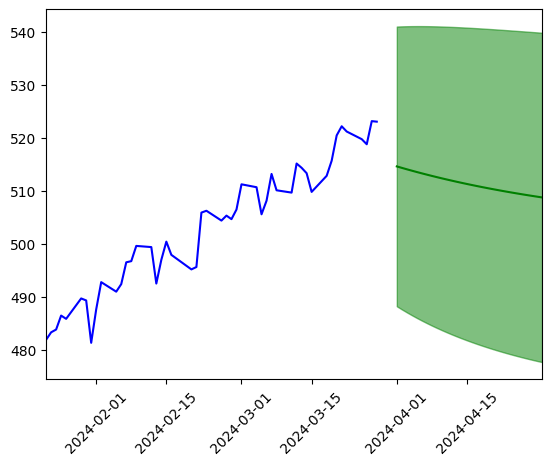

In [481]:
# Visualizing forecast
fig, ax = plt.subplots()

ax.plot(og_spy_train_timestamp, color = 'b')
plt.xlim(og_spy_train_timestamp.index[0], TEST_END);
ax.plot(predictions, color = 'g')
plt.fill_between(conf_ints.index, conf_ints.lower, conf_ints.upper, color='g', alpha=0.5)
plt.xticks(rotation = 45);

In [482]:
# standardizing indices and computing residuals
predictions.index = predictions.index.to_timestamp().normalize()
og_spy_test_timestamp = og_spy_test.copy()
og_spy_test_timestamp.index = og_spy_test_timestamp.index.to_timestamp()

df = pd.concat([og_spy_test_timestamp, predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']

residuals = df['actual'] - df['predicted']

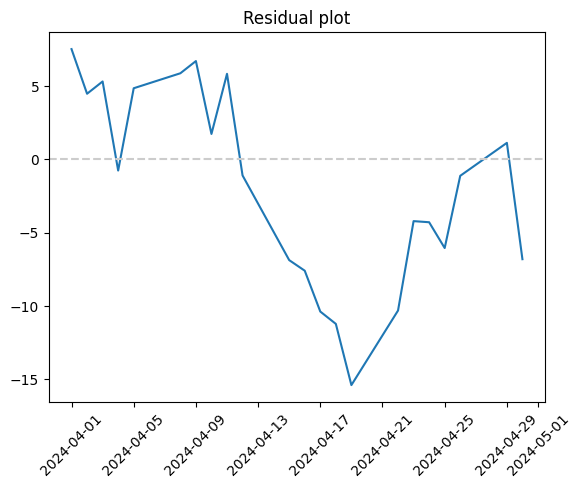

In [483]:
# plot residuals
plt.plot(residuals);
plt.xticks(rotation = 45);
plt.title('Residual plot');
plt.axhline(0, linestyle='--', color = '0.8');

The residuals don't seem like random noise, so there is some pattern in the data that our model is failing to capture.

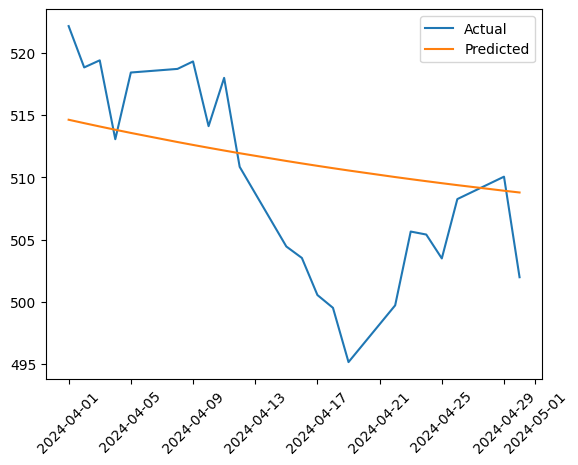

In [484]:
# Actual vs Predicted Plot
plt.plot(df['actual']);
plt.plot(df['predicted']);
plt.legend(labels = ['Actual', 'Predicted']);
plt.xticks(rotation = 45);

## Rolling Forecast Origin
### Credit: https://github.com/ritvikmath/Time-Series-Analysis/blob/master/SARIMA%20Model.ipynb
### Idea: Lets say we want to forecast k days into the future
1. Train on days 1, 2, ..., k-3 -> predict day k-2
2. Train on days 1, 2, ..., k-3, k-2 -> predict day k-1
3. Train on days 1, 2, ..., k-3, k-2, k-1 -> predict day k

Then we average all predictions

In [507]:
# Specify Order of ARIMA Model
BEST_ORDER = (1,1,0)

In [508]:
# Rolling forecast origin
rolling_predictions = pd.Series()
final_model_fit = None
for end_date in og_spy_test.index:
    train_data = spy_data[:end_date.to_timestamp()-timedelta(days=1)]
    train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')
    model = ARIMA(train_data, order = BEST_ORDER)
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    rolling_predictions.loc[end_date] = pred.loc[end_date]
    # Save final model
    final_model_fit = model_fit

In [509]:
print(final_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   69
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -185.091
Date:                Tue, 21 May 2024   AIC                            374.182
Time:                        21:06:57   BIC                            378.621
Sample:                    01-22-2024   HQIC                           375.941
                         - 04-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0494      0.125     -0.396      0.692      -0.294       0.195
sigma2        13.5439      2.422      5.593      0.000       8.797      18.290
Ljung-Box (L1) (Q):                   0.05   Jarque-

In [510]:
# Get results into a dataframe
df = pd.concat([og_spy_test, rolling_predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']
df.index = df.index.to_timestamp()

#print results RMSE
print(f"RMSE of ARIMA (rolling predictions): {root_mean_squared_error(df['actual'], df['predicted'])}")

RMSE of ARIMA (rolling predictions): 4.268917408808185


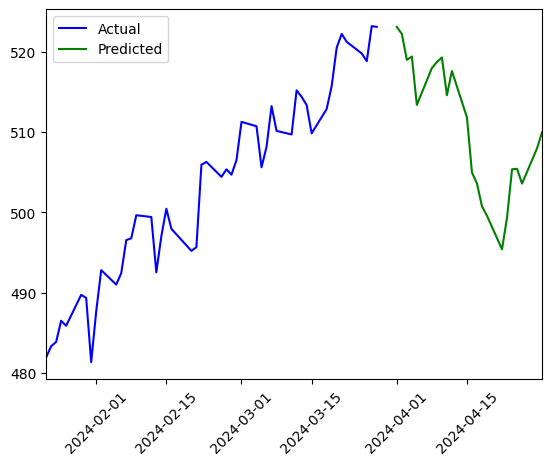

In [511]:
# Visualizing forecast
fig, ax = plt.subplots()

ax.plot(og_spy_train_timestamp, color = 'b')
plt.xlim(og_spy_train_timestamp.index[0], TEST_END);
ax.plot(df['predicted'], color = 'g')
plt.xticks(rotation = 45);
plt.legend(labels = ['Actual', 'Predicted']);

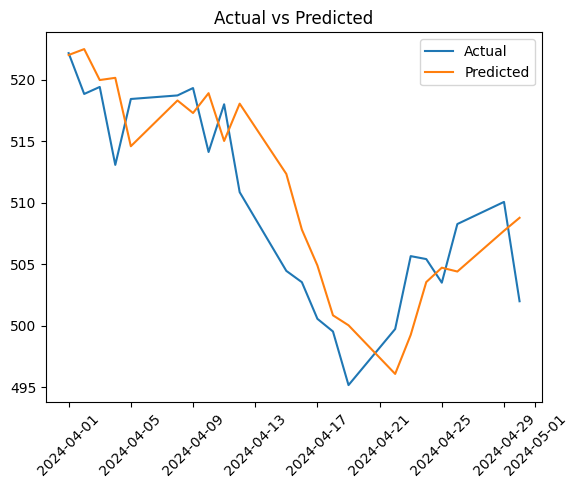

In [501]:
# Actual vs Predicted
plt.plot(df['actual']);
plt.plot(df['predicted']);
plt.legend(labels = ['Actual', 'Predicted']);
plt.xticks(rotation = 45);
plt.title('Actual vs Predicted');

Visually, the rolling forecast leads to a better fit, which is supported by the slightly better RMSE.

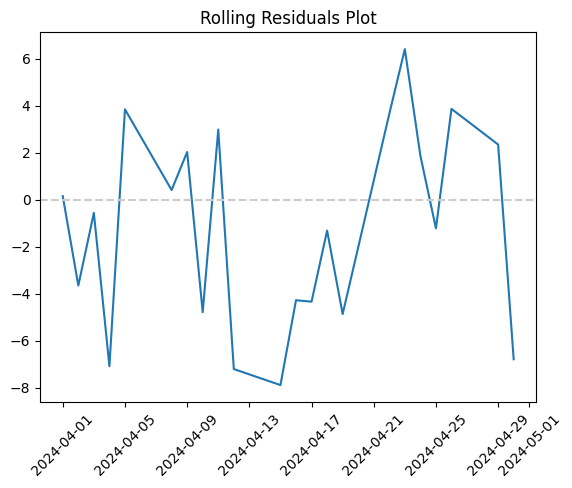

In [502]:
# Residual plot
rolling_residuals = df['actual'] - df['predicted']

plt.plot(rolling_residuals);
plt.title('Rolling Residuals Plot')
plt.xticks(rotation = 45);
plt.axhline(0, linestyle='--', color = '0.8');

Again, the residuals are not random, so our model is still failing to capture some pattern in the data.

## Random Walk Model

Random Walk will be our baseline model to compare against. The theory behind random walk is that there is no relationship between the past prices and the future prices of a stock.

So to predict the adjusted close price of a stock, we would follow

$\hat y_{T+h|T} = y_{T}$ where h is the hth day that we are forecasting and T is the last closing price we have in the data

The random walk model's residuals are not random.

## Rolling Prediction for Random Walk

In [492]:
# Rolling forecast origin
rolling_predictions = pd.Series()
for end_date in og_spy_test.index:
    train_data = spy_data[:end_date.to_timestamp()-timedelta(days=1)]
    rolling_predictions.loc[end_date] = train_data.iloc[-1]

In [493]:
# Get results into a dataframe
df = pd.concat([og_spy_test, rolling_predictions], join = 'inner', axis = 1)
df.columns = ['actual', 'predicted']
df.index = df.index.to_timestamp()

#print results RMSE
print(f"RMSE of Random Walk (rolling predictions): {root_mean_squared_error(df['actual'], df['predicted'])}")

RMSE of Random Walk (rolling predictions): 4.245316176409986


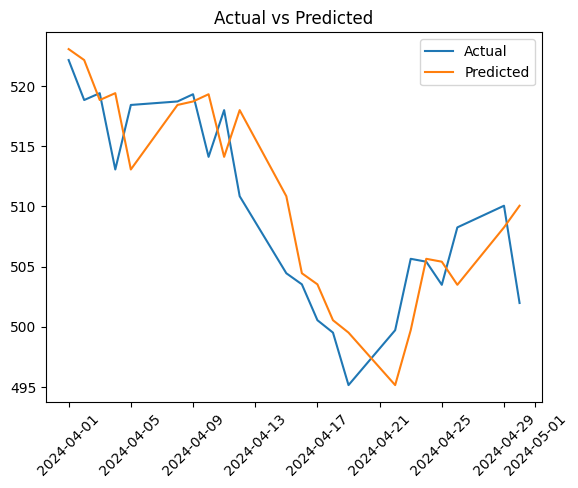

In [494]:
# Actual vs Predicted
plt.plot(df['actual']);
plt.plot(df['predicted']);
plt.xticks(rotation = 45);
plt.title("Actual vs Predicted");
plt.legend(labels = ['Actual', 'Predicted']);

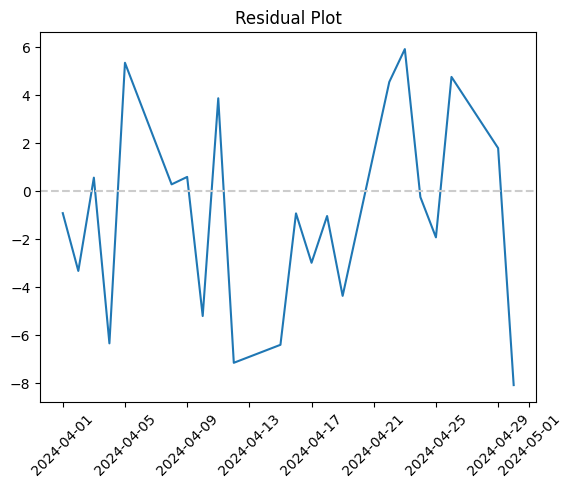

In [495]:
# Residual Plot
residuals = df['actual'] - df['predicted']
plt.plot(residuals);
plt.xticks(rotation = 45);
plt.title('Residual Plot');
plt.axhline(0, linestyle='--', color = '0.8');